# Long-Tailed Recognition via Weight Balancing
## Demonstration for the second stage training
CVPR 2022 Submission #0020


## import packages
Some packages are installed automatically if you use Anaconda. There are other packages not included in Anaconda, such as pandas, seaborn, PyTorch, and torchvision. They should be installed properly.

In [1]:
from __future__ import print_function, division
import os, random, time, copy, scipy, pickle, sys, math
from skimage import io, transform
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float

import pandas as pd
import seaborn as sn
import sklearn.metrics 
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

from utils.eval_funcs import *
from utils.dataset_CIFAR100LT import *
from utils.network_arch_resnet import *
from utils.trainval import *
from utils.plot_funcs import *
import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.8.8 (default, Apr 13 2021, 19:58:26) 
[GCC 7.3.0]
1.9.0


## Setup config parameters
 
There are several things to setup, like which GPU to use, model name, hyper-parameters, etc. Please read the comments. By default, you should be able to run this script smoothly without changing anything.

In [2]:
# fix the random seed for fair comparison. 
# NOTE that we also removed "shuffle" lines in generating long-tailed CIFAR already (cf. util.dataset_CIFAR100LT.py)
torch.manual_seed(0)
np.random.seed(0)

In [3]:
# set device, which gpu to use.
device ='cpu'
if torch.cuda.is_available(): 
    device='cuda'

In [4]:
curr_working_dir = os.getcwd()
project_name = 'demo_1'
imb_type = 'exp' # samling long-tailed training set with an exponetially-decaying function
imb_factor = 0.01 # imbalance factor = 100 = 1/0.01
    
nClasses = 100  # number of classes in CIFAR100-LT with imbalance factor 100
encoder_num_layers = 34 # network architecture is ResNet34
batch_size = 64 # batch size 
isPretrained = False

torch.cuda.device_count()
torch.cuda.empty_cache()
save_dir = path.join(curr_working_dir, 'exp', project_name)
if not os.path.exists(save_dir): os.makedirs(save_dir)

log_filename = os.path.join(save_dir, 'train.log')

## setup dataset
download the CIFAR100 dataset if there does not exist one.

In [5]:
path_to_DB = './datasets'
if not os.path.exists(path_to_DB): os.makedirs(path_to_DB)
_ = torchvision.datasets.CIFAR100(root=path_to_DB, train=True, download=True)

Files already downloaded and verified


In [6]:
path_to_DB = path.join(path_to_DB, 'cifar-100-python')

datasets = {}
dataloaders = {}

setname = 'meta'
with open(os.path.join(path_to_DB, setname), 'rb') as obj:
    labelnames = pickle.load(obj, encoding='bytes')
    labelnames = labelnames[b'fine_label_names']
for i in range(len(labelnames)):
    labelnames[i] = labelnames[i].decode("utf-8") 
    
    
setname = 'train'
with open(os.path.join(path_to_DB, setname), 'rb') as obj:
    DATA = pickle.load(obj, encoding='bytes')
imgList = DATA[b'data'].reshape((DATA[b'data'].shape[0],3, 32,32))
labelList = DATA[b'fine_labels']
total_num = len(labelList)
img_num_per_cls = get_img_num_per_cls(nClasses, total_num, imb_type, imb_factor)
new_imgList, new_labelList = gen_imbalanced_data(img_num_per_cls, imgList, labelList)
datasets[setname] = CIFAR100LT(
    imageList=new_imgList, labelList=new_labelList, labelNames=labelnames,
    set_name=setname, isAugment=setname=='train')
print('#examples in {}-set:'.format(setname), datasets[setname].current_set_len)



setname = 'test'
with open(os.path.join(path_to_DB, setname), 'rb') as obj:
    DATA = pickle.load(obj, encoding='bytes')
imgList = DATA[b'data'].reshape((DATA[b'data'].shape[0],3, 32,32))
labelList = DATA[b'fine_labels']
total_num = len(labelList)
datasets[setname] = CIFAR100LT(
    imageList=imgList, labelList=labelList, labelNames=labelnames,
    set_name=setname, isAugment=setname=='train')


print('#examples in {}-set:'.format(setname), datasets[setname].current_set_len)



dataloaders = {set_name: DataLoader(datasets[set_name],
                                    batch_size=batch_size,
                                    shuffle=set_name=='train', 
                                    num_workers=4) # num_work can be set to batch_size
               for set_name in ['train', 'test']} # 'train',



print('#train batch:', len(dataloaders['train']), '\t#test batch:', len(dataloaders['test']))

#examples in train-set: 10847
#examples in test-set: 10000
#train batch: 170 	#test batch: 157


Text(0, 0.5, '#training examples')

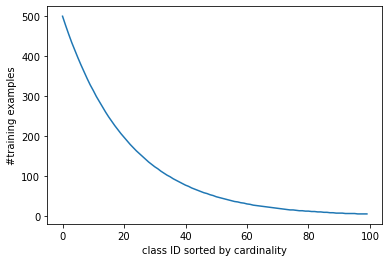

In [7]:
#preview training data distribution
plt.plot(img_num_per_cls)
plt.xlabel('class ID sorted by cardinality')
plt.ylabel('#training examples')

torch.Size([64, 3, 32, 32])


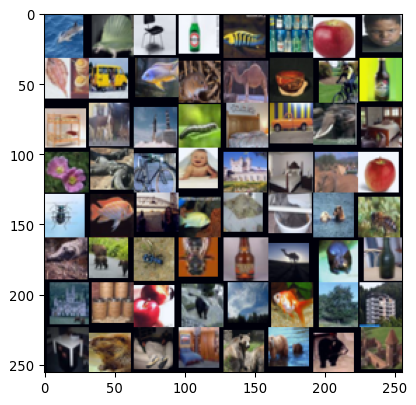

In [8]:
data_sampler = iter(dataloaders['train'])
data = next(data_sampler)
imageList, labelList = data

imageList = imageList.to(device)
labelList = labelList.type(torch.long).view(-1).to(device)

print(imageList.shape)

imList = imageList.permute(0,2,3,1).cpu().numpy()
imList -= imList.min()
imList /= imList.max()+0.0001
imList = createMontage(imList, (32, 32, 64))

fig = plt.figure(figsize=(5,5), dpi=95) # better display with larger figure
plt.imshow(imList)

torch.Size([64, 3, 32, 32])


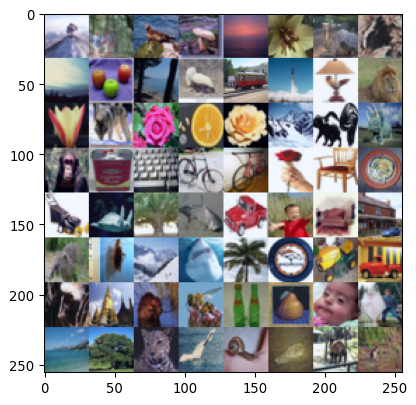

In [9]:
data_sampler = iter(dataloaders['test'])
data = next(data_sampler)
imageList, labelList = data

imageList = imageList.to(device)
labelList = labelList.type(torch.long).view(-1).to(device)

print(imageList.shape)

imList = imageList.permute(0,2,3,1).cpu().numpy()
imList -= imList.min()
imList /= imList.max()+0.0001
imList = createMontage(imList, (32, 32, 64))

fig = plt.figure(figsize=(5,5), dpi=95) # better display with larger figure
plt.imshow(imList)

# First Stage training 


In [10]:
base_lr = 0.01
total_epoch_num = 320
loss_CrossEntropy = nn.CrossEntropyLoss()

In [11]:
models= {}

## Training naively with no weight decay

In [12]:
model_name = 'naive'
weight_decay = 0 #set weight decay to 0

model = ResnetEncoder(encoder_num_layers, isPretrained, embDimension=nClasses, poolSize=4).to(device)
optimizer = optim.SGD([{'params': model.parameters(), 'lr': base_lr}], lr=base_lr, momentum=0.9, weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, total_epoch_num, eta_min=0)
print_each = 40 #print the accuracy every 10 epochs

In [13]:
trackRecords = train_model(dataloaders, model, loss_CrossEntropy, optimizer, scheduler, 
                           num_epochs=total_epoch_num, device = device, work_dir='./exp/'+project_name, 
                           model_name= model_name, print_each = print_each)


Epoch 1/320
----------
train
	loss:3.871707, acc-all:0.11054, acc-avg-cls:0.03555
test
	loss:5.019577, acc-all:0.06180, acc-avg-cls:0.06180

Epoch 41/320
----------
train
	loss:0.256311, acc-all:0.91583, acc-avg-cls:0.84314
test
	loss:4.602118, acc-all:0.35110, acc-avg-cls:0.35110

Epoch 81/320
----------
train
	loss:0.012948, acc-all:0.99640, acc-avg-cls:0.99388
test
	loss:5.134779, acc-all:0.37380, acc-avg-cls:0.37380

Epoch 121/320
----------
train
	loss:0.001897, acc-all:0.99972, acc-avg-cls:0.99974
test
	loss:5.191688, acc-all:0.39090, acc-avg-cls:0.39090

Epoch 161/320
----------
train
	loss:0.001130, acc-all:0.99972, acc-avg-cls:0.99986
test
	loss:5.298341, acc-all:0.38860, acc-avg-cls:0.38860

Epoch 201/320
----------
train
	loss:0.000550, acc-all:0.99991, acc-avg-cls:0.99998
test
	loss:5.300356, acc-all:0.39110, acc-avg-cls:0.39110

Epoch 241/320
----------
train
	loss:0.000585, acc-all:0.99982, acc-avg-cls:0.99988
test
	loss:5.301886, acc-all:0.39200, acc-avg-cls:0.39200

Ep

In [13]:
# load model with best epoch accuracy
path_to_clsnet = os.path.join(save_dir, model_name+'_best.paramOnly')
model.load_state_dict(torch.load(path_to_clsnet, map_location=device));

model.to(device);
model.eval();
models['naive'] = model

In [14]:
print_accuracy(model, dataloaders, np.array(new_labelList), device = device)

acc avgClass:  40.0%
Many: 67.4% Medium: 38.1% Few: 10.4%


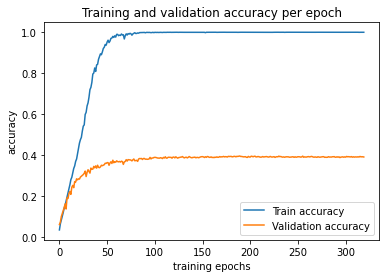

In [22]:
plot_per_epoch_accuracy(trackRecords)

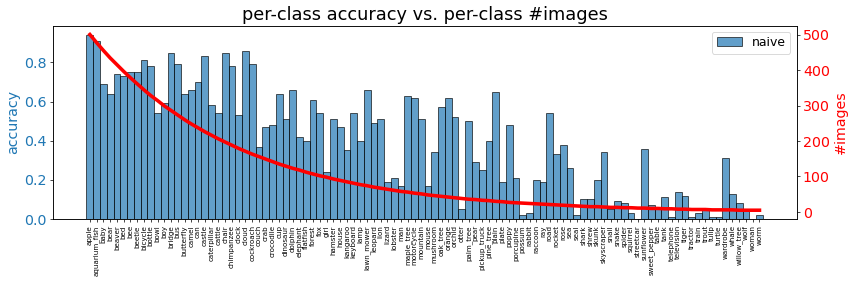

In [23]:
plot_per_class_accuracy(models, dataloaders, labelnames, img_num_per_cls, nClasses= nClasses, device = device)

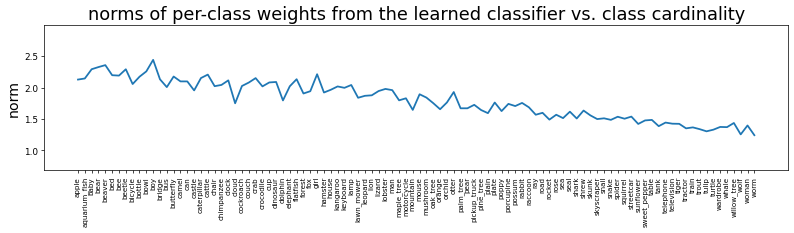

In [24]:
plot_norms(model, labelnames)

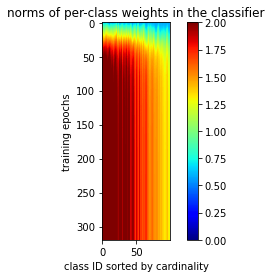

In [25]:
plot_weights_evolution(trackRecords)

## Training with weight decay

We found the value for the weight decay parameter $\lambda$ using Grid Search

In [25]:
model_name = 'with_WD_model'
weight_decay = 5e-3 #set weight decay value

model = ResnetEncoder(encoder_num_layers, isPretrained, embDimension=nClasses, poolSize=4).to(device)
optimizer = optim.SGD([{'params': model.parameters(), 'lr': base_lr}], lr=base_lr, momentum=0.9, weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, total_epoch_num, eta_min=0)
print_each = 40 #print the accuracy every 10 epochs

In [27]:
trackRecords = train_model(dataloaders, model, loss_CrossEntropy, optimizer, scheduler, 
                           num_epochs=total_epoch_num, device = device, work_dir='./exp/'+project_name, 
                           model_name= model_name, print_each = print_each)


Epoch 1/320
----------
train
	loss:3.827622, acc-all:0.11828, acc-avg-cls:0.03868
test
	loss:4.926713, acc-all:0.06010, acc-avg-cls:0.06010

Epoch 41/320
----------
train
	loss:1.071715, acc-all:0.71006, acc-avg-cls:0.41194
test
	loss:3.307501, acc-all:0.30090, acc-avg-cls:0.30090

Epoch 81/320
----------
train
	loss:0.752208, acc-all:0.79782, acc-avg-cls:0.50998
test
	loss:3.324181, acc-all:0.32960, acc-avg-cls:0.32960

Epoch 121/320
----------
train
	loss:0.549216, acc-all:0.85332, acc-avg-cls:0.59596
test
	loss:3.341311, acc-all:0.32560, acc-avg-cls:0.32560

Epoch 161/320
----------
train
	loss:0.354914, acc-all:0.91094, acc-avg-cls:0.71241
test
	loss:3.047981, acc-all:0.36000, acc-avg-cls:0.36000

Epoch 201/320
----------
train
	loss:0.196453, acc-all:0.95556, acc-avg-cls:0.82837
test
	loss:3.095949, acc-all:0.39780, acc-avg-cls:0.39780

Epoch 241/320
----------
train
	loss:0.063027, acc-all:0.99309, acc-avg-cls:0.96163
test
	loss:2.924929, acc-all:0.43410, acc-avg-cls:0.43410

Ep

In [26]:
# load model with best epoch accuracy
path_to_clsnet = os.path.join(save_dir, model_name+'_best.paramOnly')
model.load_state_dict(torch.load(path_to_clsnet, map_location=device));

model.to(device);
model.eval();
models['with WD'] = model

In [27]:
print_accuracy(model, dataloaders, np.array(new_labelList), device = device)

acc avgClass:  47.9%
Many: 78.0% Medium: 46.9% Few: 13.9%


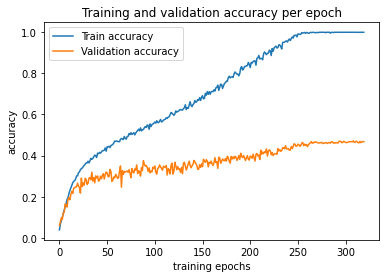

In [30]:
plot_per_epoch_accuracy(trackRecords)

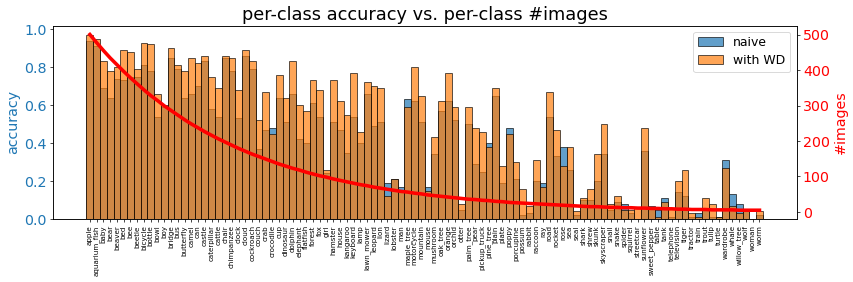

In [28]:
plot_per_class_accuracy(models, dataloaders, labelnames, img_num_per_cls, nClasses= nClasses, device = device)

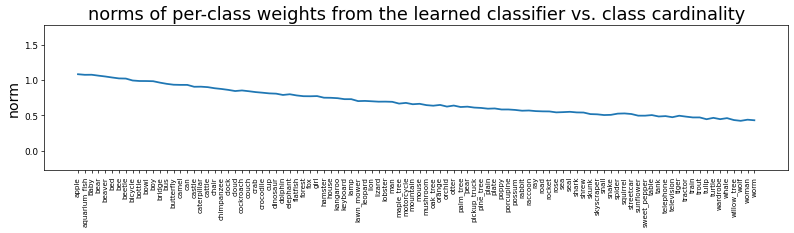

In [29]:
plot_norms(model, labelnames)

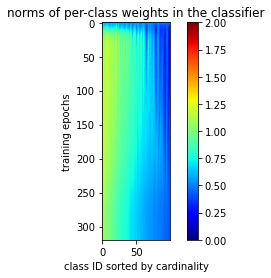

In [33]:
plot_weights_evolution(trackRecords)